# Transfer learning with photonic quantum PS

This Jupyter notebook investigates a photonic quantum PS agent in a specific transfer learning scenario, see: 

Fulvio Flamini, Marius Krumm, Lukas J. Fiderer, Thomas Mueller, Hans J. Briegel, <em>Reinforcement learning via single-photon quantum walks</em>. 

In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models

from joblib import Parallel, delayed

We pick fixed seeds for the random number generators of Pytorch and Numpy.

In [2]:
fixRNG = True

if fixRNG:
    torch.manual_seed(3133742)
    np.random.seed(3133742)

Folders to export numerical results:

In [3]:
# This is for saving figures and the data used to draw them
dirNameFigures = "TransferFigures"
if not os.path.exists(dirNameFigures):
    os.mkdir(dirNameFigures)
  
# This is for saving PyTorch models
dirNameModels = "TransferModels"
if not os.path.exists(dirNameModels):
    os.mkdir(dirNameModels)
    
# This is for saving PyTorch parameters
dirNameParameters = "TransferParameters"
if not os.path.exists(dirNameParameters):
    os.mkdir(dirNameParameters)
    
dirNameUnitaries = "TransferUnitaries"
if not os.path.exists(dirNameUnitaries):
    os.mkdir(dirNameUnitaries)

## Numerical simulation of interferometer setups

For our photonics Quantum PS agent, we will numerically simulate interferometer setups using Mach-Zehnder interferometers (MZI) as their basic building blocks. One of these setups is the Clements layout which allows to implement arbitrary unitaries for single photons, see:
William R. Clements et al., Optica Vol. 3, Issue 12, pp. 1460-1465 (2016).

Another setup which we consider is a tree-shaped layout.

In [4]:
def MZI(phases):
    """
    Defines a universal 2x2 unitary which implements a tunable
    Mach-Zender interferometer characterized by two phase-parameters
    """
    
    M = torch.tensor([[1.0+1.0j , 1.0+1.0j],[1.0+1.0j , 1.0+1.0j]])
    M[0,0] = torch.exp(1j*phases[0])*torch.cos(phases[1])
    M[0,1] = -torch.sin(phases[1]) 
    M[1,0] = torch.exp(1j*phases[0])*torch.sin(phases[1])
    M[1,1] = torch.cos(phases[1])
    return M

In [5]:
def ClementsLayer(dim, withSkip , phases):
    """
    The Clements layout uses layers of parallel Mach-Zender interferometers, 
    sometimes with a parallel wire (depends on number of modes and whether layer-index 
    is odd or even).
    """
    if withSkip == 0:
        if dim % 2 == 0:
            for k in range(dim//2):
                if k == 0:
                    M = MZI(phases[0:2])
                else:
                    M = torch.block_diag(M, MZI(phases[2*k : (2*k)+2]))
        if dim % 2 == 1:
            for k in range((dim-1)//2):
                if k == 0:
                    M = MZI(phases[0:2])
                else:
                    M = torch.block_diag(M, MZI(phases[2*k : (2*k)+2]))
            M = torch.block_diag(M, torch.ones(size = [1,1]))
    if withSkip == 1:
        if dim % 2 == 0:
            M = torch.ones(size = [1,1])
            for k in range((dim-2)//2):
                M = torch.block_diag(M, MZI(phases[2*k : (2*k)+2]))
            M = torch.block_diag(M, torch.ones(size = [1,1]))
        if dim % 2 == 1:
            M=torch.ones(size=[1,1])
            for k in range((dim-1)//2):
                M = torch.block_diag(M , MZI(phases[2*k : (2*k)+2]))
    return M

The full Clements layout is now simply given by multiplying the layers.

In [6]:
def Clements(dim, ClementsPhases, outputPhases):
    M = torch.eye(dim , dtype = torch.cfloat)
    for k in range(dim):
        M = torch.matmul(ClementsLayer(dim, withSkip = k % 2, phases = ClementsPhases[k,:]), M)
    M = torch.matmul(torch.diag(torch.exp(1j*outputPhases)) ,M)
    return M

An alternative layout that we will use arranges the MZI into a tree-shaped pattern.

In [7]:
def TreeLayer( InputState, Phases, num_MZI):
    """
    A layer for the interometer tree. For each component of the input state, there are 
    two components in the layer output. They are obtained by feeding the corresponding
    layer input mode into a MZI, leaving the other MZI input mode dark.
    """
    
    for m in range(num_MZI):
        CurrentState = torch.zeros(size = [2,1] , dtype = torch.cfloat)
        CurrentState[0,0] = InputState[m,0]
        CurrentState = torch.matmul(MZI(Phases[2*m : 2*m+2]) , CurrentState)
        if m == 0:
            StateSoFar = CurrentState
        else:
            StateSoFar = torch.cat([StateSoFar, CurrentState])
    return StateSoFar

In [8]:
def Tree(dim, TreePhases, OutputPhases):
    """
    The full tree, implemented by multiplying the layers. For simplicity, we assume
    that the phases are provided in a rectangular arrays, with the first index labeling
    the layer and the second the position in the layer. The drawback is that many of
    the phases in this array do not actually get used.
    """
    num_layers = int(np.ceil(np.log2(dim)))
    LayerOut = torch.tensor([[1.0 +0.00j]])
    for layer in range(num_layers):
        if layer < num_layers - 1:
            LayerOut = TreeLayer(LayerOut, Phases = TreePhases[layer, :] , num_MZI = LayerOut.size(0))
        elif layer == num_layers - 1:
            #If the number of output modes is not a power of 2, then the last layer 
            #will have fewer MZIs, and instead there will be some parallel waveguides.
            LastNumMZI = (dim - (2**(num_layers - 1))) 
            WorkState = LayerOut[0:LastNumMZI, :]      #Input to last layer
            Remaining = LayerOut[LastNumMZI : , :]     #Parallel waveguides
            WorkState = TreeLayer(WorkState, TreePhases[layer , :], LastNumMZI)
            LayerOut = torch.cat([WorkState, Remaining], )
            LayerOut = torch.matmul(torch.diag(torch.exp(1.0j*OutputPhases)) , LayerOut)
    return LayerOut
            
             

## Toy model for transfer learning: The scenario of Eva et al.

In this Jupyter notebook, we will work with the toy model of 

B. Eva, K. Ried, T. Müller, and H. J. Briegel, “How a minimal learning agent can infer the existence of unobserved variables in a complex environment,” Minds & Machines, pp. 1–35, 2022, Online first, DOI = https://doi.org/10.1007/s11023-022-09619-5 , arXiv:1910.06985.

This toy model considers an idealized experimental setting: An agent is given a physical object, characterized by three observables, each of which can take 3 values. The agent can perform one of several experiments, each of them being determined by exactly one observable. In Ried et al., the goal was that the agent learns an explicit representation of the underlying observables and their values.

In our case, we consider the same toy model, but our focus is on particular aspects of transfer learning, rather than the discovery of observables. We consider a 3-layer quantum PS. For now, we will perform a layer-wise training. The second layer is directly trained to learn the values of the observables. This is a crucial difference to Ried et al, who wanted the agent to passively learn a representation in which each middle layer vertex corresponds to one value of one observable.

Our interest is in the third layer. Different from the classical PS agent, we want to demonstrate that the Quantum PS agent can perform well on experiments requiring the knowledge of two observables.

In [9]:
num_observables = 3
num_values = 3 #number of values each observable can take

Now, we create a list of the single, two and three observable experiments. Each experiment asks whether certain observables have certain values.

In [10]:
One_Obs_Exps = []
experiment_index = 0

for obs in range(num_observables):
    for value in range(num_values):
        exp_title = 'Experiment '+str(experiment_index)+' checks whether observable '
        exp_title += str(obs)+' has value '+str(value)
        One_Obs_Exps.append( [exp_title , obs, value])
        experiment_index += 1
        
Two_Obs_Exps = []
experiment_index = 0

for obs1 in range(0, num_observables-1, 1):
    #We don't want several copies of the same experiment. Therefore, we make the convention that obs2 is always larger than obs1.
    for obs2 in range(obs1+1, num_observables, 1):
        for value1 in range(num_values):
            for value2 in range(num_values):
                exp_title = 'Experiment '+str(experiment_index)+' checks whether observable '
                exp_title += str(obs1)+' has value '+str(value1) +' and whether observable '
                exp_title += str(obs2)+' has value '+str(value2)
                Two_Obs_Exps.append( [exp_title , obs1, value1, obs2, value2])
                experiment_index += 1
                
Three_Obs_Exps = []
experiment_index = 0

for obs1 in range(0, num_observables-2, 1):
    for obs2 in range(obs1+1, num_observables-1, 1):
        for obs3 in range(obs2+1, num_observables, 1):
            for value1 in range(num_values):
                for value2 in range(num_values):
                    for value3 in range(num_values):
                        exp_title = 'Experiment '+str(experiment_index)+' checks whether observable '
                        exp_title += str(obs1)+' has value '+str(value1) +' and whether observable '
                        exp_title += str(obs2)+' has value '+str(value2) + ' and whether observable '
                        exp_title += str(obs3)+' has value ' + str(value3)
                        Three_Obs_Exps.append( [exp_title , obs1, value1, obs2, value2, obs3, value3])
                        experiment_index += 1

Next, we can define our reward function for the middle layer. It is +1 or -1 depending on whether the agent identifies the value of the chosen observable correctly or not. 

In [11]:
def rewardLayer2(percept, predicted_answer):
    chosenObs = predicted_answer // num_values
    chosenValue = predicted_answer % num_values

    if percept[chosenObs] == chosenValue:
        return 1
    else:
        return -1

Now, we define the reward function for the third layer. For a given experiment, it checks whether the agent's answers are correct. If they are, the reward is +1, otherwise it is -1. 

We also output whether the right answer is yes or no: A no-answer is much more likely, so we will later give a larger weight to a correct yes-answer.

In [12]:
def rewardLayer3(percept, experiment_index, predicted_answer , experiment_list = One_Obs_Exps):
    rightAnswer = 1
    for targetObsInd, targetValueInd in zip(range(1, len(experiment_list[experiment_index]), 2) , range(2, len(experiment_list[experiment_index]), 2)):
        #Read observable and the value asked for by the experiment
        obs = experiment_list[experiment_index][targetObsInd]
        suggested_value = experiment_list[experiment_index][targetValueInd]
        actual_value = percept[obs]
        if suggested_value != actual_value:
            #rightAnswer is 1 if the observable value asked for by the experiment is the actual value of the percept, otherwise 0.
            rightAnswer = 0

    if rightAnswer == predicted_answer:
        return 1, rightAnswer
    else:
        return -1, rightAnswer

Here, you can double check that the reward function works correctly.

In [13]:
print(Two_Obs_Exps[9])
rewardLayer3([1,0,0], 9 , 1, Two_Obs_Exps)


['Experiment 9 checks whether observable 0 has value 0 and whether observable 2 has value 0', 0, 0, 2, 0]


(-1, 0)

Next, we define our loss function inspired by a classical 2-layer PS. It is intended to be used with experience replay.

As distance measure between probabilities, we use the relative entropy (Kullback-Leibler divergence). 

Since we will generate the percepts i.i.d. we will not use the glow or forgetting mechanisms. This allows us to approximate the PS update rule enforced by the loss function as $$p_{new} = p_{old} + r$$ for the chosen action given the percept.

To make the loss function numerically simpler, we will not include actions that were not chosen into the loss function. This also helps us to avoid unnormalized probability distributions resulting from using probabilities instead of h-values in our approximation. Since we do not consider full probability distributions anymore, for each sample in the batch we apply the relative entropy to $(p_{new},1-p_{new})$ and $(p_{old}+r,1-[p_{old}+r])$.

To prevent that $ p_{new} $ is smaller than 0 or larger than 1, we use nested ReLUs to cut off $ p_{new} $ at 0 and 1.

In [14]:
def MultiPSlossFunction(pGuesses, pOlds, rewards):
    """
    PS loss function using the approximation p_{new , k} = p_{old , k} + r_k for chosen actions a_k.
    This function is intended to be used with experience replay, and k is the index of the sample in the batch.
    Non-chosen actions and percepts are dropped, we only reinforce rewards, not old models.
    """
    relu = torch.nn.ReLU()
    pTargets = relu(pOlds+torch.tensor(rewards))
    pTargets = 1.0 - relu(1.0 - pTargets)
    
    # We use regularizers to prevent log(0) and division by 0
    reguLow = torch.tensor(0.00001)
    reguHigh = torch.tensor(1.00001)
    
    Loss = torch.sum(pTargets*torch.log((pTargets+reguLow)/(pGuesses+reguLow)) + (1.0-pTargets)*torch.log((reguHigh-pTargets)/(reguHigh-pGuesses)))
    #print(Loss)
    return(Loss)

As our next step, we define our Quantum PS agent.

The middle layer (observable layer) is implemented via interferometer trees, one for each percept. While this does not allow different percepts to interfere, it is much simpler to optimize. We will later consider three loss functions that need to be optimized simultaneously, and using seperate trees at least allows us to avoid additional unitary constraints.

For the last layer (experiment layer), we use an exchangable Clements layout. This is shared by all percepts (allowing for interference), but each experiment gets its own. This is our toy model for transfer learning.

In [15]:
class QPSTreeOneExp(nn.Module):
    def __init__(self, num_percepts = num_values**num_observables, num_hidden = num_observables*num_values, ini = "fixed"):
        super(QPSTreeOneExp, self).__init__()
        self.num_percepts = num_percepts
        self.num_hidden = num_hidden 
        
        self.U_percept_bag = []
        self.U_full_bag = []
        
        self.ini = ini
        
        #Initialize the variational phases, either randomly or to some fixed values. 
        #For the middle layer, we will define far more phases than we actually use. 
        #We use a rectangular array with one index for the tree layer, and one index 
        #for the waveguide within that layer. This makes the code much more readable. 
        #For the last layer, we will use post-selection to remove all outputs except 
        #for two waveguides associated to a yes or no answer. The experiment Clements 
        #unitary therefore has a dimensionality corresponding to the size of the 
        #middle layer, i.e. #observables * #values.
        
        # Percept to middle layer parameters, first index is the percept:
        if ini == "fixed":
            self.CPhases_percept_bag = nn.Parameter( ( (torch.pi/4)*torch.ones(size = [ num_percepts, int(np.ceil(np.log2(self.num_hidden))) , self.num_hidden], dtype = torch.float32) ))
            self.OPhases_percept_bag = ( nn.Parameter( ( (torch.pi/4)*torch.ones(size = [ num_percepts, self.num_hidden], dtype = torch.float32) ) ) )
        if ini == "random":
            self.CPhases_percept_bag = nn.Parameter( ( (2.0*torch.pi)*torch.randn(size = [num_percepts , int(np.ceil(np.log2(self.num_hidden))) , self.num_hidden], dtype = torch.float32) )) 
            self.OPhases_percept_bag = nn.Parameter( ( (2.0*torch.pi)*torch.randn(size = [num_percepts , self.num_hidden], dtype = torch.float32) ) )
        
        # Middle to final layer parameters:
        if ini == "fixed":
            self.CPhases_task_bag = nn.Parameter( ( (torch.pi/4)*torch.ones(size = [self.num_hidden, self.num_hidden], dtype = torch.float32) ) ) 
            self.OPhases_task_bag = nn.Parameter( ( (torch.pi/4)*torch.ones(size = [self.num_hidden], dtype = torch.float32) ) ) 
        if ini == "random":
            self.CPhases_task_bag = nn.Parameter( ( (2.0*torch.pi)*torch.randn(size = [self.num_hidden, self.num_hidden], dtype = torch.float32) ) ) 
            self.OPhases_task_bag = nn.Parameter( ( (2.0*torch.pi)*torch.randn(size = [self.num_hidden], dtype = torch.float32) ) ) 
            
        
        
        #We initilialize some dummy unitaries that we will overwrite with the interferometer unitaries
        for p in range(num_percepts):
            self.U_percept_bag.append(torch.zeros( size = [num_hidden,num_hidden] , dtype = torch.cfloat))
            self.U_full_bag.append(torch.zeros( size = [num_hidden,num_hidden] , dtype = torch.cfloat))
            
        
        #After initializing the variational phases, we also generate the corresponding interferometer unitaries.
        self.recalculate_full_unitaries()
        

        
        
        
        
    # Since we will exchange the last layer often, we implement a method to reset the last layer.
    def reset_task(self):
        if self.ini == "fixed":
            self.CPhases_task_bag = nn.Parameter( ( (torch.pi/4)*torch.ones(size = [self.num_hidden, self.num_hidden], dtype = torch.float32) ))
            self.OPhases_task_bag = nn.Parameter( ( (torch.pi/4)*torch.ones(size = [self.num_hidden], dtype = torch.float32) ) )
        if self.ini == "random":
            self.CPhases_task_bag = nn.Parameter( ( (2.0*torch.pi)*torch.randn(size = [self.num_hidden, self.num_hidden], dtype = torch.float32) ) )
            self.OPhases_task_bag = nn.Parameter( ( (2.0*torch.pi)*torch.randn(size = [self.num_hidden], dtype = torch.float32) ) )
        self.recalculate_full_unitaries()
        
        
        
        
    # Converts percepts of the form [2,1,2] into a single integer (injectively).
    # This single integer, called the index, will often be used to refer to the percept.
    def convert_percept_to_index(self, percept): 
        onedimvalue = 0
        for j in range(num_observables):
            onedimvalue += (num_values**j)*percept[j]
        return onedimvalue
    
    
    
    def recalculate_percept_unitary(self, percept):
        percept_index = self.convert_percept_to_index(percept)
        self.U_percept_bag[percept_index] = Tree(dim = self.num_hidden , TreePhases = self.CPhases_percept_bag[percept_index], OutputPhases = self.OPhases_percept_bag[percept_index] )
    
    
    def recalculate_full_unitary(self, percept, is_index = 0):
        if is_index == 0:
            percept_index = self.convert_percept_to_index(percept)
        elif is_index == 1:
            percept_index = percept
        self.U_percept_bag[percept_index] = Tree(dim = self.num_hidden , TreePhases = self.CPhases_percept_bag[percept_index], OutputPhases = self.OPhases_percept_bag[percept_index])
        self.U_task = Clements(dim = self.num_hidden , ClementsPhases = self.CPhases_task_bag, outputPhases = self.OPhases_task_bag)
        self.U_full_bag[percept_index] = torch.matmul(self.U_task, self.U_percept_bag[percept_index])  
        
        
    def recalculate_full_unitaries(self):
        for percept_index in range(self.num_percepts):
            self.recalculate_full_unitary(percept_index, is_index = 1)
            
            
            
            
    # This method returns the probabilities for actions in the middle layer, by taking the modulus square of the amplitudes.
    def probs2(self, percept):
        self.recalculate_percept_unitary(percept)
        percept_index = self.convert_percept_to_index(percept)
        torchUnnormedProbs = torch.square(torch.abs(self.U_percept_bag[percept_index][ 0:num_observables*num_values , 0]))
        torchNormedProbs = (torchUnnormedProbs/torch.sum(torchUnnormedProbs))
        return torchNormedProbs.clone()
    
    
    
            
    # The next method allows us to randomly sample an action in the middle layer, using the probabilities from above.
    def sample2(self, percept):
        torchProbs = self.probs2(percept)
        probs = torchProbs.clone().detach().numpy()
        sampled_action = np.random.choice(np.arange(torchProbs.size(0)) , p = probs)
        return sampled_action   
    
    
    
    # This method returns the probabilities that the middle layer picks a certain observable to predict. These will be used to implement a curiosity mechanism. This function simply sums the probabilities from above over all values per observable.
    def probs2Observables(self, percept):
        torchProbs = self.probs2(percept)
        probsObs = torch.zeros(size = [num_observables], dtype = torch.float32)
        for obsIndex in range(num_observables):
            probsObs[obsIndex] = torch.sum(torchProbs[obsIndex*num_values : obsIndex*num_values + num_values])
        return probsObs
    
    
    # Returns the output phases of the middle layer. These will later be forced to be close to 0, such that interference is not prevented by random phases in the middle layer.
    def phases2(self, percept):
        self.recalculate_percept_unitary(percept)
        percept_index = self.convert_percept_to_index(percept)
        phases = torch.zeros(size = [self.num_hidden], dtype = torch.cfloat)
        for j in range(num_observables*num_values):
            if self.U_percept_bag[percept_index][ j , 0] != 0.0:
                phases[j] = torch.angle(self.U_percept_bag[percept_index][j , 0].clone())
            else:
                # Since the origin does not have a well-defined phase, we define it to be 0.
                phases[j] = 0.0
        return phases
    
    
    # Action probabilities for the third layer. Here, post-selection is applied such that only 2 answers are possible.
    def probs3(self, percept):
        self.recalculate_full_unitary(percept)
        percept_index = self.convert_percept_to_index(percept)
        torchUnnormedProbs = torch.square(torch.abs(self.U_full_bag[percept_index][0 : 2, 0]))
        torchNormedProbs = torchUnnormedProbs/torch.sum(torchUnnormedProbs)
        return torchNormedProbs
    
    
    # Sample a random action for the last layer, using the probabilities from above.
    def sample3(self , percept):
        torchNormedProbs = self.probs3(percept)
        probs = torchNormedProbs.clone().detach().numpy()
        sampled_action = np.random.choice(np.arange(torchNormedProbs.size(0)) , p = probs)
        return sampled_action 
        

Time to create our agent!

In [16]:
#ini_choice = "random"
ini_choice = "fixed"

TreeAgent = QPSTreeOneExp(num_percepts = num_values**num_observables, num_hidden = num_values*num_observables, ini = ini_choice)

Now, we define the function that will train the middle layer. The environment uniformly samples (in particular i.i.d.) a percept. The agent picks an observable, and predicts the value of that observable. In addition to the PS loss function, we have two more contributions to the full loss function:

1) To prevent that interference effects in the last layer get weakened by random phases in the middle layer, we force those phases to be close to 0.

2) Values of different observables cannot interfere well constructively and destructively if one observable has much more weight than the other. Therefore, we use a curiosity mechanism that encourages the agent to pick each observable with uniform probability. This is implemented via the Shannon negentropy of the observables in the middle layer. 

We use experience replay. This means we collect many (percept, action, reward) samples, and then use them as a training data batch for updating. We point out that our batch is chosen so large that it will contain the entire percept space. 

In [17]:
def train_obs_with_replay(Agent = TreeAgent, replay_memory_size = 600, num_rounds = 20000, num_optimizer_steps = 10, coeff_Shannon = 1.0, coeff_phase = 0.01, learning_rate = 0.01):

    logfile_obs = open(dirNameFigures+"/logfile_obs.txt", "w")
    logfile_obs.close()
    
    # The experience replay memory
    reward_memory = []
    percept_memory = []
    action_memory = []

    # Memory for creating a plot at the end
    round_list = []
    Shannon_list = []
    acc_list = []
    phase_list = []

    num_acc = replay_memory_size
    
    counter = 0
    accuracy = 0.0
    
    last_round_to_draw_open = True
    
    perfection = 0
    
    add_Shannon_and_perfection = False

    for roun in range(num_rounds):
        #Each round corresponds to sampling one action.
        #counter tells us the size of the replay memory so far.
        counter += 1
        
        #Randomly sample percept.
        percept = []
        for observables in range(num_observables):
            percept.append(np.random.randint(num_values))
            
        #Add training sample to memory
        percept_memory.append(percept.copy())
        agentGuess = Agent.sample2(percept)
        action_memory.append(agentGuess)
        r = 0.1 * rewardLayer2(percept, agentGuess)
        reward_memory.append(r)
        
        # Count how many right answers agent has given.
        if r > 0.0:
            accuracy += 1.0
            
        # When we have collected enough samples, evaluate and store the accuracy. Then reset it.
        if counter == num_acc:
            round_list.append(roun)
            accuracy /= num_acc
            acc_list.append(accuracy)
            print("Accuracy: "+ str(accuracy))
            logfile_obs = open(dirNameFigures+"/logfile_obs.txt", "a")
            logfile_obs.write("Accuracy: "+ str(accuracy)+" \n")
            logfile_obs.close()
            last_acc = accuracy
            accuracy = 0.0
            counter = 0
            # The following will be used in an early stopping criterion.
            add_Shannon_and_perfection = True
        
        #When the replay memory has reached its maximum size, we train the agent.
        if len(reward_memory) == replay_memory_size:
            num_percepts = num_values**num_observables
            
            # When the agent reached a high accuracy, we make the learning-rate much smaller to allow for fine-tuning of the variational phases.
            if last_acc >= 0.95:
                current_learning_rate = 0.1 * learning_rate
            else:
                current_learning_rate = learning_rate
            
            # Tell the optimizer to vary the phases of the middle layer. 
            paramlist = []
            paramlist.append( {'params' : Agent.CPhases_percept_bag})
            paramlist.append( {'params' : Agent.OPhases_percept_bag})
            
            optimizer = optim.Adam(paramlist, lr = current_learning_rate)
            optimizer.zero_grad()
            
            Agent.recalculate_full_unitaries()
            
            # Read the probabilities p_{old} for the PS loss function, to be used for the targets
            oldProbs = torch.zeros(size = [replay_memory_size], dtype = torch.float32)
            for memory_index in range(replay_memory_size):
                current_percept = percept_memory[memory_index].copy()
                percept_index = Agent.convert_percept_to_index(current_percept)
                probsGuessOld  = Agent.probs2(percept = current_percept).clone().detach()
                oldProbs[memory_index] = probsGuessOld[action_memory[memory_index]].clone()

            num_steps = num_optimizer_steps

            # Iterate over the number of optimization steps.
            for step in range(num_steps):
                
                Agent.recalculate_full_unitaries()
                optimizer.zero_grad()
                
                # Read the current probabilities p_{new} to compare them to the targets.
                guessProbs = torch.zeros(size = [replay_memory_size] , dtype = torch.float32)
                for memory_index in range(replay_memory_size):
                    current_percept = percept_memory[memory_index].copy()
                    percept_index = Agent.convert_percept_to_index(current_percept)
                    probsGuessFullPercept  = Agent.probs2(percept = current_percept)
                    guessProbs[memory_index] = probsGuessFullPercept[action_memory[memory_index]].clone()
                    
                    # Now, also collect the relative phases and the Shannon negentropy of the observables.
                    if memory_index == 0:
                        phasesForLoss = Agent.phases2(percept = current_percept)
                        probsGuessObs  = Agent.probs2Observables(percept = current_percept)
                        Shannon = (torch.log(torch.tensor(num_observables))-torch.sum(-probsGuessObs.clone()*torch.log(probsGuessObs.clone()+ 0.0)))
                        
                        # The following is not used for training, just for generating the graph.
                        # Since we only care about relative phases of answers that have a significant probability to occur, we weight the relative phases with the probability.
                        weightedPhases = Agent.probs2(percept = current_percept).clone().data*phasesForLoss.clone().data
                    else: 
                        phasesForLoss = torch.cat( (phasesForLoss, Agent.phases2(percept = current_percept)), 0 )
                        probsGuessObs = Agent.probs2Observables(percept = current_percept)
                        Shannon = (Shannon + torch.log(torch.tensor(num_observables))-torch.sum(-probsGuessObs.clone()*torch.log(probsGuessObs.clone()+0.0)))
                        
                        #For graph and stopping only
                        extraWeightedPhases = Agent.probs2(percept = current_percept).data*Agent.phases2(percept = current_percept).data
                        weightedPhases = torch.cat((weightedPhases , extraWeightedPhases), 0)
                
                # Now, we put the loss functions together.
                phaseLoss = torch.sum(torch.abs(phasesForLoss))
                PSloss = MultiPSlossFunction(guessProbs, oldProbs.clone().detach(), reward_memory)
                fullLoss = (coeff_phase*phaseLoss + 1.0*PSloss + coeff_Shannon*Shannon)
                fullLoss.backward()
                
                # The following outputs help to judge the training of the agent.
                if counter % 10 == 0 and step % 20 == 0:
                    print("Amplitudes for percept [0,0,0]: ") 
                    print(Agent.U_percept_bag[0])
                    logfile_obs = open(dirNameFigures+"/logfile_obs.txt", "a")
                    logfile_obs.write("Amplitudes for percept [0,0,0]: \n ")
                    logfile_obs.write(str(Agent.U_percept_bag[0].data))
                    logfile_obs.write("\n")
                    logfile_obs.close()

                optimizer.step()
                optimizer.zero_grad()
                
                Agent.recalculate_full_unitaries()
                
            # When we have collected enough samples to evaluate the accuracy:
            # Collect the average Shannon loss and phase loss to be plotted at the end
            if add_Shannon_and_perfection:
                add_Shannon_and_perfection = False
                ave_Shannon = Shannon.data/replay_memory_size
                Shannon_list.append(ave_Shannon.numpy())
                ave_weighted_phase = torch.sum(torch.abs(weightedPhases))/replay_memory_size
                phase_list.append(ave_weighted_phase.data.numpy())
                print("L1 norm of phases: " + str(phaseLoss.data.numpy()))
                print("Average weighted phase: " + str(phase_list[-1]))
                print(" ")
                logfile_obs = open(dirNameFigures+"/logfile_obs.txt", "a")
                logfile_obs.write("L1 norm of phases: " + str(phaseLoss.data.numpy())+"\n ")
                logfile_obs.write("Average weighted phase: " + str(phase_list[-1]) + " \n \n ")
                logfile_obs.close()
                
                # Early stopping criterion: 
                # When the agent performed near perfect several times in a row, and the average weighted phase is very small, stop the training. 
                if last_acc >= 0.99 and phase_list[-1] < 0.1:
                    last_acc = 0.0
                    perfection += 1
                    #Store the last round to draw in the plot at the end.
                    if last_round_to_draw_open:
                        last_round_to_draw_open = False
                        last_round_to_draw = roun
                else:
                    perfection = 0

            percept_memory = []
            action_memory = []
            reward_memory = []
            
        if perfection >= 10:
            break
            
    # Creation of the plot      
    #fig, ax = plt.subplots(figsize=(7, 4), layout='constrained')
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(round_list[0:last_round_to_draw+1], acc_list[0:last_round_to_draw+1], label= 'accuracy (1.0 means 100 percent)')  
    ax.plot(round_list[0:last_round_to_draw+1], Shannon_list[0:last_round_to_draw+1], label='Shannon negentropy of observable choice (0.0 is uniform)')   
    ax.plot(round_list[0:last_round_to_draw+1], phase_list[0:last_round_to_draw+1], label="Average phase weighted with action probability" )
    ax.set_xlabel('round')  
    ax.set_ylabel(' ')  
    ax.set_title("Training of the middle layer with experience replay")  
    ax.legend();  
    plt.savefig(dirNameFigures+"/obs_training.png")
    plt.show()
    
    ave_entropy = ((replay_memory_size*torch.log(torch.tensor(num_observables)))-Shannon)/replay_memory_size
    
    print("Last averaged observable Shannon entropy over "+str(replay_memory_size)+" samples: " + str(ave_entropy.data.numpy()))
    
    
    
    # Save data for the figures:
    fileName = dirNameFigures + "/MiddleLayerRounds.txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, round_list[0:last_round_to_draw+1])
        
    fileName = dirNameFigures + "/MiddleLayerAccuracies.txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, acc_list[0:last_round_to_draw+1])
        
    fileName = dirNameFigures + "/MiddleLayerShannonNegEntropies.txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, Shannon_list[0:last_round_to_draw+1])
        
    fileName = dirNameFigures + "/MiddleLayerPhases.txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, phase_list[0:last_round_to_draw+1])
    
    
    # At last, we save the model itself
    torch.save(Agent.state_dict(), dirNameModels+'/MiddleLayerModel.pt')
    
    # and the percept unitaries
    for percept in range(Agent.num_percepts):
        if percept == 0:
            writeMode = 'w'
        else:
            writeMode = 'a'
            
        fileName = dirNameUnitaries + "/PerceptTrafo.txt"
        with open(fileName , writeMode) as datafile:
            datafile.write("Percept index:" +str(percept)+ " \n \n")
            datafile.write( str(Agent.U_percept_bag[percept].clone().data.numpy()))
            datafile.write(" \n \n ")
            
        fileName = dirNameParameters + "/PerceptCPhases.txt"    
        with open(fileName , writeMode) as datafile:
            datafile.write("Percept index:" +str(percept)+ " \n \n")
            datafile.write( str(Agent.CPhases_percept_bag[percept].clone().data.numpy()))
            datafile.write(" \n \n ")   
            
        fileName = dirNameParameters + "/PerceptOPhases.txt"    
        with open(fileName , writeMode) as datafile:
            datafile.write("Percept index:" +str(percept)+ " \n \n")
            datafile.write( str(Agent.OPhases_percept_bag[percept].clone().data.numpy()))
            datafile.write(" \n \n ")              
    
    

Now, it's time to train the middle layer!

In [18]:
%%capture output_obs
train_obs_with_replay(Agent = TreeAgent, replay_memory_size = 600, num_rounds = 100000, num_optimizer_steps = 10, coeff_Shannon = 10.0, coeff_phase = 1.0, learning_rate = 0.01)

In [19]:
print(output_obs)

Accuracy: 0.2966666666666667
Amplitudes for percept [0,0,0]: 
tensor([[-0.1768-1.7678e-01j],
        [-0.1768-1.7678e-01j],
        [-0.3536+1.8078e-09j],
        [-0.3536+1.8078e-09j],
        [-0.3536+1.8078e-09j],
        [-0.3536+1.8078e-09j],
        [-0.3536+1.8078e-09j],
        [-0.3536+1.8078e-09j],
        [-0.3536+1.8078e-09j]], grad_fn=<MmBackward0>)
L1 norm of phases: 14510.125
Average weighted phase: 2.7186325
 
Accuracy: 0.37333333333333335
Amplitudes for percept [0,0,0]: 
tensor([[-0.2220-0.2715j],
        [-0.1829-0.2237j],
        [-0.3650+0.0740j],
        [-0.3497+0.1478j],
        [-0.2864+0.1211j],
        [-0.2739+0.1158j],
        [-0.3349+0.1416j],
        [-0.2864+0.1211j],
        [-0.2864+0.1211j]], grad_fn=<MmBackward0>)
L1 norm of phases: 12830.126
Average weighted phase: 2.3979173
 
Accuracy: 0.495
Amplitudes for percept [0,0,0]: 
tensor([[-0.2219-0.3348j],
        [-0.1485-0.2240j],
        [-0.2966+0.1254j],
        [-0.2888+0.2974j],
        [-0.1922+0

Next, we output the middle layer. It is supposed to be an array of 0's and $\frac{1}{\sqrt{3}} \approx 0.577$'s. A 0 represents that an observable does not have a certain value, a large value indicates that it does. The array is arranged as:

[values of observable 0, values of observable 1 , ...]

In [20]:
TreeAgent.U_percept_bag

[tensor([[ 5.7799e-01+3.5160e-04j],
         [ 6.0735e-04-3.3691e-04j],
         [-6.6208e-05+9.4470e-05j],
         [ 5.7765e-01+8.4154e-05j],
         [ 3.1608e-04+5.9912e-05j],
         [ 2.8872e-04+2.6627e-05j],
         [ 5.7641e-01-1.4631e-03j],
         [-1.0572e-04+4.3704e-06j],
         [-7.4272e-05+3.0705e-06j]], grad_fn=<MmBackward0>),
 tensor([[-2.7267e-04+1.9667e-04j],
         [ 5.7761e-01-1.7365e-02j],
         [-7.2659e-05+2.4042e-04j],
         [ 5.7818e-01+4.5458e-04j],
         [-7.4669e-04-1.2802e-04j],
         [ 6.3694e-05-3.4107e-07j],
         [ 5.7598e-01+3.1617e-03j],
         [-1.5725e-04+7.0591e-06j],
         [-1.7438e-04+7.8277e-06j]], grad_fn=<MmBackward0>),
 tensor([[-4.6229e-05-9.1598e-05j],
         [-5.5044e-05-1.0906e-04j],
         [ 5.1462e-01+2.6192e-01j],
         [ 5.7724e-01-8.8824e-05j],
         [-6.0125e-04+1.9036e-04j],
         [-3.6515e-04+1.4377e-05j],
         [ 5.7737e-01+2.1807e-03j],
         [ 6.6920e-04-5.0187e-05j],
         [ 6.6

Next, we write the function that trains the last layer, while keeping the middle layer fixed. So this is the transfer learning process.

In [21]:
def trainOnExperimentsReplayProcess(experiment_index, Agent = TreeAgent, exp_list = One_Obs_Exps, num_rounds = 10000, replay_size = 100, num_optimizer_steps = 1, learning_rate = 0.01 ):
    
    exp_index = experiment_index
    
    # Prepare a file to save the training progress of the experiment
    logfile_exps = open(dirNameFigures+"/logfile_exp_" +str(exp_index)+".txt", "w")
    logfile_exps.write(" \n ")
    logfile_exps.close()
    
    replay_memory_size = replay_size
    
    # How many experiments are there, and for how many observables does one experiment want to know the values?
    num_experiments = len(exp_list)
    num_obs_per_exp = (len(exp_list[0])-1)//2
    
    counter = 0
    accuracy = 0.0
    weighted_accuracy = 0.0
    for_full_accuracy = 0.0
    for_full_weighted_accuracy = 0.0
    normalization = 0.0
    
    #Replay memory
    reward_memory = []
    percept_memory = []
    action_memory = []   
    
    #For evaluating the accuracy
    round_list = []
    acc_list = []
    weighted_list = []
    
    #For plots
    exp_list_for_graph = []
    acc_exp_list = []
    weighted_exp_list = []


    exp_list_for_graph.append(experiment_index)
    Agent.reset_task()
        
    print(exp_list[experiment_index][0])
    print(" ")
    logfile_exps = open(dirNameFigures+"/logfile_exp_" +str(exp_index)+".txt", "a")
    logfile_exps.write(str(exp_list[experiment_index][0]) + "\n \n ")
    logfile_exps.close()
        
    for roun in range(num_rounds):
        counter += 1
            
        #Randomly sample percept.
        percept = []
        for observables in range(num_observables):
            percept.append(np.random.randint(num_values))
        percept_memory.append(percept.copy())    
            
        # Sample action and reward, also remember whether the answer is yes or no.
        predicted_answer = Agent.sample3(percept)
        action_memory.append(predicted_answer)
        answeredRight, rightAns = rewardLayer3(percept, experiment_index, predicted_answer , experiment_list = exp_list)
        r = 0.1*answeredRight
            
        # A no-answer is much more likely than a yes-answer, since all percept values of the relevant observables have to match the values suggested by the experiment. Therefore, we give the reward for a yes-answer a weight factor such that true yes- and no-answers have the same contribution to the weighted accuracy.
        r = r*(((num_values**num_obs_per_exp)-1.0)**rightAns)
            
        # For the accuracy, remember how many right answers were given. 
        # We will also calculate a weighted accuracy with the same weight factors as the reward.
        # For this weighted accuracy, we also need to store the normalization, which is the maximal value the weighted unnormalized accuracy can achieve if the agent always gives the right answer.
        if r > 0.0:
            accuracy += 1.0
            weighted_accuracy += ((num_values**num_obs_per_exp)-1.0)**rightAns
        normalization += ((num_values**num_obs_per_exp)-1.0)**rightAns
            
        # When we collected enough samples, evaluate the accuracy.
        if counter == replay_size:
            accuracy /= replay_size
            for_full_accuracy = accuracy
            weighted_accuracy /= normalization
            for_full_weighted_accuracy = weighted_accuracy
                
            print("Accuracy: "+ str(accuracy))
            print("Weighted accuracy: "+ str(weighted_accuracy))
            print(" ")
            logfile_exps = open(dirNameFigures+"/logfile_exp_" +str(exp_index)+".txt", "a")
            logfile_exps.write("Accuracy: "+ str(accuracy)+" \n ")
            logfile_exps.write("Weighted accuracy: "+ str(weighted_accuracy)+" \n \n ")
            logfile_exps.close()
                    
            #Save the progress of the training.  
            round_list.append(roun)
            acc_list.append(accuracy)
            weighted_list.append(weighted_accuracy)
            
            # Resets for the next batch
            accuracy = 0.0
            weighted_accuracy = 0.0
            normalization = 0.0
            counter = 0
        reward_memory.append(r)

            
        # When the replay memory is big enough, it's time to train.
        # When the agent is already very good, we use a smaller learning rate for fine-tuning.
        if len(reward_memory) == replay_memory_size:
            if for_full_accuracy >= 0.95:
                current_learning_rate = 0.1*learning_rate
            else:
                current_learning_rate = learning_rate
                    
            optimizer = optim.Adam([Agent.CPhases_task_bag, Agent.OPhases_task_bag], lr = current_learning_rate)
            optimizer.zero_grad()
                
            # Read the probabilities p_{old} to be used for the calculation of the targets.
            oldProbs = torch.zeros(size = [replay_memory_size], dtype = torch.float32)
            for memory_index in range(replay_memory_size):
                current_percept = percept_memory[memory_index].copy()
                percept_index = Agent.convert_percept_to_index(current_percept)
                probsGuessOld  = Agent.probs3(percept = current_percept).clone().detach()
                oldProbs[memory_index] = probsGuessOld[action_memory[memory_index]].clone()
               
            # Now, the optimizer steps
            num_steps = num_optimizer_steps
            for step in range(num_steps):
                optimizer.zero_grad()
                    
                # Read the probabilities p_{new} to be tuned
                guessProbs = torch.zeros(size = [replay_memory_size] , dtype = torch.float32)
                for memory_index in range(replay_memory_size):
                    #print(percept_memory)
                    current_percept = percept_memory[memory_index].copy()
                    percept_index = Agent.convert_percept_to_index(current_percept)
                    probsGuessFullPercept  = Agent.probs3(percept = current_percept)
                    guessProbs[memory_index] = probsGuessFullPercept[action_memory[memory_index]].clone()

                PSloss = MultiPSlossFunction(guessProbs, oldProbs.clone().detach(), reward_memory)
                    
                fullLoss = 1.0*PSloss 
                fullLoss.backward()
                        
                optimizer.step()
                optimizer.zero_grad()
                
            # Wipe replay memory
            reward_memory = []
            action_memory = []
            percept_memory = []
                
    # Update accuracy lists    
    acc_exp_list.append(for_full_accuracy)
    weighted_exp_list.append(for_full_weighted_accuracy)
        
        
    # Save the models 
        
    fileName = dirNameModels+"/AgentExp"+str(experiment_index)+".pt"
    torch.save(Agent.state_dict(), fileName)
        
    fileName = dirNameParameters + "/TaskCPhasesExp"+str(experiment_index)+".txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, Agent.CPhases_task_bag.clone().data.numpy() )
            
    fileName = dirNameParameters + "/TaskCPhasesExp"+str(experiment_index)+"Rounded.txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, Agent.CPhases_task_bag.clone().data.numpy() , fmt = '%0.4f')
        
    fileName = dirNameParameters + "/TaskOPhasesExp"+str(experiment_index)+".txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, Agent.OPhases_task_bag.clone().data.numpy() )
            
    fileName = dirNameParameters + "/TaskOPhasesExp"+str(experiment_index)+"Rounded.txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, Agent.OPhases_task_bag.clone().data.numpy() , fmt = '%0.4f')
            
    fileName = dirNameUnitaries + "/U_task"+str(experiment_index)+".txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, Agent.U_task.clone().data.numpy())
        
    fileName = dirNameUnitaries + "/U_task"+str(experiment_index)+"Rounded.txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, Agent.U_task.clone().data.numpy() , fmt = '%0.4f')
            
    fileName = dirNameUnitaries + "/U_full_bag"+str(experiment_index)+".txt"
    for percept in range(Agent.num_percepts):
        if percept == 0:
            writeMode = 'w'
        else:
            writeMode = 'a'
        with open(fileName, writeMode) as datafile:
            datafile.write("Percept index: "+str(percept)+" \n \n ")
            datafile.write(str(Agent.U_full_bag[percept].clone().data.numpy()))
            datafile.write("\n \n ")
                
        
    return(round_list, acc_list, weighted_list, exp_list_for_graph, acc_exp_list, weighted_exp_list)

    
    
            
        

The following function takes care of the parallelization of the training of the final layers, collects the data, and draws the figures.

In [22]:
def trainAndPlotTasks(num_cores = 1, Agent = TreeAgent, exp_list = One_Obs_Exps, num_rounds = 10000, replay_size = 100, num_optimizer_steps = 1, learning_rate = 0.01):
    
    # Number of final layers to train
    num_exps = len(exp_list)
    
    # Collects data for graphs
    exp_list_for_graph = []
    acc_exp_list = []
    weighted_exp_list = []
    
    
    
    # Define a training function with our hyperparameters already configured. 
    def trainMulti(exp_index):
        # Clone the agent with trained middle layer. This prevents the processes for the training of the final layers to overwrite each other.
        taskAgent = QPSTreeOneExp(num_percepts = num_values**num_observables, num_hidden = num_values*num_observables, ini = ini_choice)
        taskAgent.load_state_dict(Agent.state_dict().copy())
    
        # Define a function that has all the hyperparameters set right, and only expects the experiment index of the final layer as input.
        result = trainOnExperimentsReplayProcess(experiment_index = exp_index, Agent = taskAgent, exp_list = exp_list, num_rounds = num_rounds, replay_size = replay_size, num_optimizer_steps = num_optimizer_steps, learning_rate = learning_rate )
        return result
    
    
    
    # Parallelize the training of the final layers
    full_result_list = Parallel(n_jobs=num_cores)(delayed(trainMulti)(a) for a in range(num_exps))
    
    for exp, (rl, al, wl, el, ael, wel) in enumerate(full_result_list):
        # Extract the data of the training progress for the first experiment
        if exp == 0:
            round_list = rl
            acc_list = al
            weighted_list = wl
        
        # Combine the accuracies of the different experiments to put them all into one plot
        exp_list_for_graph.extend(el)
        acc_exp_list.extend(ael)
        weighted_exp_list.extend(wel)
    
    
    
    
    # Save the data used for the graphs
    fileName = dirNameFigures + "/Exp0RoundList.txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, np.array(round_list))
        
    fileName = dirNameFigures + "/Exp0AccList.txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, np.array(acc_list))
        
    fileName = dirNameFigures + "/Exp0WeightedAccList.txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, np.array(weighted_list))
        
    fileName = dirNameFigures + "/ExpListForGraph.txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, np.array(exp_list_for_graph))
        
    fileName = dirNameFigures + "/AccExpList.txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, np.array(acc_exp_list))
        
    fileName = dirNameFigures + "/WeightedAccExpList.txt"
    with open(fileName, 'w') as datafile:
        np.savetxt(datafile, np.array(weighted_exp_list))

    
    
    

    # Output and plot accuracies.
    fig, ax = plt.subplots(figsize=(7.0, 5.0))
    ax.plot(round_list, acc_list, label='accuracy') 
    ax.plot(round_list, weighted_list, label='weighted_accuracy') 
    ax.set_xlabel('round')  
    ax.set_title("Training for one experiment with two observables")  
    ax.legend();  
    plt.savefig(dirNameFigures+"/exp0_training.png")
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(7.0, 5.0))
    ax2.plot(exp_list_for_graph, acc_exp_list, label='accuracy')  
    ax2.plot(exp_list_for_graph, weighted_exp_list, label='weighted_accuracy')  
    ax2.set_xlabel('experiment')  
    ax2.set_title("Accuracies for experiments with two observables")  
    ax2.legend();  
    plt.savefig(dirNameFigures+"/exps_final_accs.png")
    plt.show()
    
    
    

Now, we can start the parallelized training of all the final layers. The top block contains the hyperparameters of our choice. 

Experiment 2 checks whether observable 0 has value 0 and whether observable 1 has value 2
 
Accuracy: 0.406
Weighted accuracy: 0.25695216907675195
 
Accuracy: 0.542
Weighted accuracy: 0.5760869565217391
 
Accuracy: 0.602
Weighted accuracy: 0.6782296650717703
 
Accuracy: 0.66
Weighted accuracy: 0.7864077669902912
 
Accuracy: 0.674
Weighted accuracy: 0.7985232067510548
 
Accuracy: 0.72
Weighted accuracy: 0.8325740318906606
 
Accuracy: 0.8
Weighted accuracy: 0.8632768361581921
 
Accuracy: 0.83
Weighted accuracy: 0.9089935760171306
 
Accuracy: 0.87
Weighted accuracy: 0.9271300448430493
 
Accuracy: 0.91
Weighted accuracy: 0.9507119386637459
 
Accuracy: 0.946
Weighted accuracy: 0.9666011787819253
 
Accuracy: 0.964
Weighted accuracy: 0.9801324503311258
 
Accuracy: 0.958
Weighted accuracy: 0.9775160599571735
 
Accuracy: 0.966
Weighted accuracy: 0.9783989834815756
 
Accuracy: 0.968
Weighted accuracy: 0.9738041002277904
 
Accuracy: 0.986
Weighted accuracy: 0.9916963226571768
 
Accuracy: 0.98
Wei

/Users/krumm/opt/anaconda3/envs/QPS/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Experiment 0 checks whether observable 0 has value 0 and whether observable 1 has value 0
 
Accuracy: 0.63
Weighted accuracy: 0.7715269804822044
 
Accuracy: 0.706
Weighted accuracy: 0.8195067264573991
 
Accuracy: 0.724
Weighted accuracy: 0.838973162193699
 
Accuracy: 0.752
Weighted accuracy: 0.866235167206041
 
Accuracy: 0.802
Weighted accuracy: 0.8890134529147982
 
Accuracy: 0.842
Weighted accuracy: 0.9078179696616102
 
Accuracy: 0.846
Weighted accuracy: 0.9018338727076591
 
Accuracy: 0.864
Weighted accuracy: 0.9219288174512055
 
Accuracy: 0.83
Weighted accuracy: 0.907608695652174
 
Accuracy: 0.822
Weighted accuracy: 0.8935406698564593
 
Accuracy: 0.85
Weighted accuracy: 0.923155737704918
 
Accuracy: 0.828
Weighted accuracy: 0.8949152542372881
 
Accuracy: 0.868
Weighted accuracy: 0.930379746835443
 
Accuracy: 0.866
Weighted accuracy: 0.9254727474972191
 
Accuracy: 0.868
Weighted accuracy: 0.9260089686098655
 
Accuracy: 0.862
Weighted accuracy: 0.9232480533926585
 
Accuracy: 0.86
Weigh

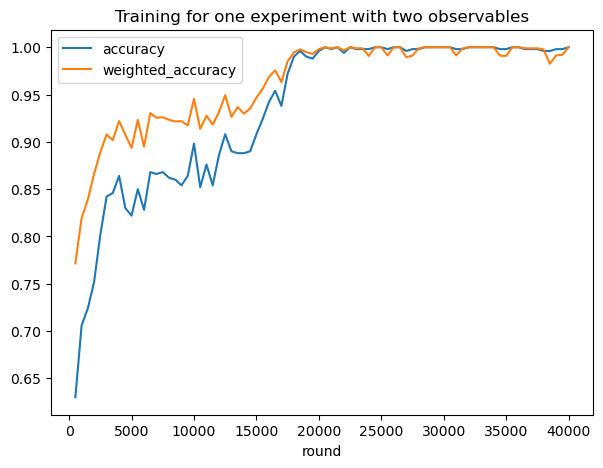

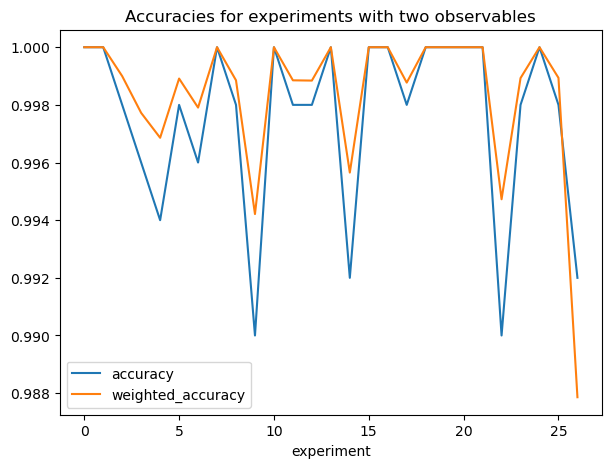

In [23]:
Agent = TreeAgent
exp_list = Two_Obs_Exps
num_rounds = 40000
replay_size = 500
num_optimizer_steps = 10
learning_rate = 0.01
num_cores = 6






# Run the parallelized training of the final layers and save results
trainAndPlotTasks(num_cores = num_cores, Agent = TreeAgent, exp_list = exp_list, num_rounds = num_rounds, replay_size = replay_size, num_optimizer_steps = num_optimizer_steps, learning_rate = learning_rate )